In [1]:
import numpy as np
import numpy

In [2]:
from PIL import Image
kk = Image.open('PennFudanPed/PNGImages/FudanPed00001.png')
np.shape(kk)

FileNotFoundError: [Errno 2] No such file or directory: 'PennFudanPed/PNGImages/FudanPed00001.png'

In [3]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

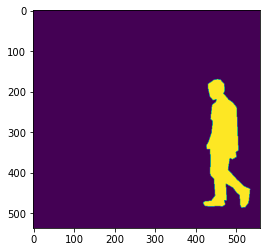

dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd'])
tensor([419., 170., 534., 485.])
tensor([1, 1])
tensor([0])
tensor([35358., 36225.])
tensor([0, 0])


In [4]:
import sys

dataset = PennFudanDataset('PennFudanPed/')
dataset[0]
import matplotlib.pyplot as plt
# print(dataset[0][0]) ### <- image
plt.imshow(dataset[0][1]['masks'][0])
plt.imshow(dataset[0][1]['masks'][1])
plt.show()
print(dataset[0][1].keys()) ### <- image
print(dataset[0][1]['boxes'][1])
print(dataset[0][1]['labels'])
print(dataset[0][1]['image_id'])
print(dataset[0][1]['area'])
print(dataset[0][1]['iscrowd'])

In [ ]:
dataset[0][1]['boxes'][0]

In [ ]:
plt.imshow(dataset[0][1]['masks'][1])

In [ ]:
plt.imshow(dataset[0][1]['masks'][0].mul(255).byte().detach().numpy())
# Image.fromarray(dataset[0][1]['masks'][0].mul(255).byte().numpy())
# Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [5]:
dataset[0][1]['masks'][0]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [ ]:
dataset[42][1]['masks'].shape

In [ ]:
print(dataset[42][1]['boxes'][1])
print(dataset[42][1]['labels'])
print(dataset[42][1]['image_id'])
print(dataset[42][1]['area'])
print(dataset[42][1]['iscrowd'])

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions1 = model(x)           # Returns predictions



In [ ]:
np.shape(predictions1)

In [ ]:
predictions1[0]

In [ ]:
predictions1[1]

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import torch.nn as nn

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchsummary import summary

from engine import train_one_epoch, evaluate
import utils
import transforms as T
# from torchsummary import summary as summary_


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)#.features
    # print(model.in_channels)
    # print(model.out_channels)
    model.backbone.body.conv1 = nn.Conv2d(11, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    print("in_features", in_features) #
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    print("in_features_mask:", in_features_mask)
    print("hidden_layer:", hidden_layer)
    print("num_classes:", num_classes)
    # in_features_mask: 256
    # hidden_layer: 256
    # num_classes: 2

    return model

num_classes = 2
model = get_model_instance_segmentation(num_classes)
# print(model)
model.eval()
x = [torch.rand(11, 128, 128), torch.rand(1, 128, 128)]
x = [torch.rand(11, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)
print(np.shape(predictions))

In [ ]:
predictions[0].keys()

In [ ]:
predictions[1].keys()

In [ ]:
predictions[0]['labels']

In [ ]:
predictions[0]['boxes']

In [ ]:
predictions[0]['masks'].shape

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(predictions[0]['masks'][0][0].detach().numpy())

In [ ]:
predictions[0]['masks'][0][0]

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())


In [ ]:
predictions[0]['masks'][0][0]

In [ ]:
plt.imshow(predictions[0]['masks'][0][0].detach().numpy())